Aims: 
- Overlap DNAme, RNAme and RNA expression. 
<!-- ### ideas 

methylated ... 


RNA expression vs. RNA methylation sctter plot

- filter down to expressed genes 
- filter down to hyper methylated genes due to decitabine  -->

In [2]:
from functools import reduce
import pathlib
import pandas as pd 
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text # https://stackoverflow.com/questions/34693991/repel-annotations-in-matplotlib

# sys.path.append('/rumi/shams/abe/CanDI/')
sys.path.append('/data_gilbert2/backups/aarab/CanDI')
sys.path.append('../')

from CanDI import candi as can

In [3]:
from venn import venn 

In [4]:
from scripts.util import *

In [5]:
# import stringdb

# def run_enrichment(genes):
#     string_ids = stringdb.get_string_ids(genes)
#     enrichment_df = stringdb.get_enrichment(string_ids.queryItem).sort_values('number_of_genes',ascending=False)
#     df = enrichment_df[['inputGenes','p_value','fdr','description','term']]
#     return df

In [6]:
gene_id2name = pd.read_csv('~/genomes/hg38/gencode.v34/gene2name-gencode.v34.csv.gz').set_index('Unnamed: 0')

## Load data

### Bisulfite-seq

In [529]:
hl60_DNAme_diff = pd.read_csv(
    '../DAC/Bisulfite-seq/delta_CpG_promoters_all_table.txt',sep='\t'
    # '../DAC/Bisulfite-seq/delta_CpG_DMR.txt',sep='\t'
)

In [530]:
hl60_DNAme_diff = hl60_DNAme_diff.loc[
    hl60_DNAme_diff.groupby('feature.name')['meth.diff'].idxmax()
].set_index('feature.name')

### Our RNA-seq data

exp

In [531]:
hl60_RNAexp_diff = pd.read_csv(
    '../DAC/RNA-seq/exp/hl60_120h_delta_exp_table.txt',sep='\t'
)[['gene_name','log2FoldChange','pvalue']].dropna()

In [532]:
hl60_RNAexp_diff = hl60_RNAexp_diff.loc[
    hl60_RNAexp_diff.groupby('gene_name')['log2FoldChange'].idxmax()
].set_index('gene_name')

stbl

In [533]:
hl60_RNAstbl_diff = pd.read_csv(
    '../DAC/RNA-seq/stbl/delta_stbl_table.txt',sep='\t'
)[['gene_name','hl60_120h_log2FC','hl60_120h_pvalue']].dropna().set_index('gene_name')
hl60_RNAstbl_diff.columns= ['log2FC','pvalue']

### Our meRIP-seq data

In [534]:
# `exomePeak` result
hl60_RNAme = pd.read_csv(
    '../DAC/meRIP-seq/exomepeak/WINDOW-50-STEP-5-LENGTH-150-ENRICH-1/peak.bed'
    ,sep='\t')

hl60_RNAme_diff = pd.read_csv('../DAC/meRIP-seq/radar/result.sig.txt',sep='\t')[['name','logFC','p_value']]

https://stackoverflow.com/questions/43936521/python-group-rows-in-dataframe-and-select-abs-max-value-in-groups-using-pandas

In [535]:
hl60_RNAme_diff = hl60_RNAme_diff.loc[hl60_RNAme_diff.groupby('name')['logFC'].idxmax()].set_index('name')

# Intersect

In [536]:
## differential DNA CpG methylation in promoter 
hyper_DNAme,hypo_DNAme = find_top(
    hl60_DNAme_diff,
    value='meth.diff', value_thr=20, stat='pvalue', stat_thr=0.001,silent=False
)

hypo_DNAme = set(hypo_DNAme.index)
hyper_DNAme = set(hyper_DNAme.index)

up:  64
down: 2688


In [537]:
## differential RNA m6A methylation 
hyper_RNAme,hypo_RNAme = find_top(
    hl60_RNAme_diff,
    value='logFC', value_thr=2, stat='p_value', stat_thr=0.001,silent=False
)

hyper_RNAme = set(hyper_RNAme.index)
hypo_RNAme = set(hypo_RNAme.index)

up:  816
down: 171


In [538]:
## differential RNA expression
up_RNAexp,down_RNAexp = find_top(
    hl60_RNAexp_diff,
    value='log2FoldChange', value_thr=2, stat='pvalue', stat_thr=0.01,silent=False
)

up_RNAexp = set(up_RNAexp.index)
down_RNAexp = set(down_RNAexp.index)

up:  846
down: 97


In [539]:
## differential RNA stbl
up_RNAstbl,down_RNAstbl = find_top(
    hl60_RNAstbl_diff,
    value='log2FC', value_thr=.5, stat='pvalue', stat_thr=0.05,silent=False
)

up_RNAstbl = set(up_RNAstbl.index)
down_RNAstbl = set(down_RNAstbl.index)

up:  93
down: 139


#### hypo DNAme

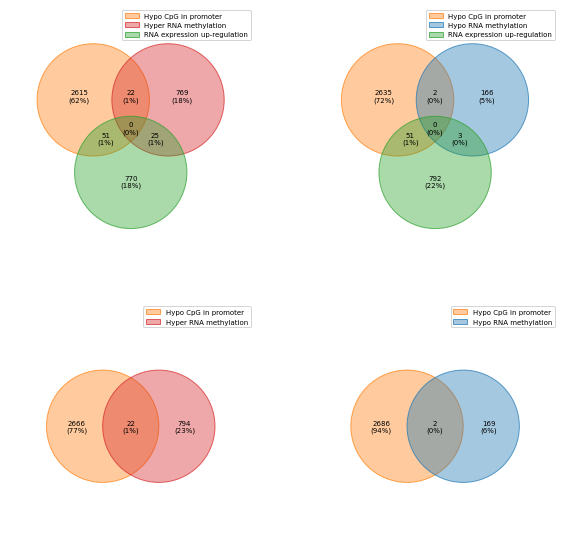

In [540]:
# https://github.com/LankyCyril/pyvenn/blob/master/pyvenn-demo.ipynb
# https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html
# cmap="tab20b"

f, axes = plt.subplots(2,2,figsize=(10,10))

fontsize=7

venn(
    {
        "Hypo CpG in promoter":hypo_DNAme,
        "Hyper RNA methylation":hyper_RNAme,
        "RNA expression up-regulation":up_RNAexp,
    },
    cmap=['#ff7f0e', '#d62728', '#2ca02c'],#['r','b','y'],
    alpha = 0.4,
    fontsize=fontsize,legend_loc="upper right",ax=axes[0,0],
    fmt="{size}\n({percentage:.0f}%)",
)

venn(
    {
        "Hypo CpG in promoter":hypo_DNAme,
        "Hypo RNA methylation":hypo_RNAme,
        "RNA expression up-regulation":up_RNAexp,
    },
    cmap=['#ff7f0e', '#1f77b4', '#2ca02c'],
    alpha = 0.4,
    fontsize=fontsize,legend_loc="upper right",ax=axes[0,1],
    fmt="{size}\n({percentage:.0f}%)",
)

venn(
    {
        "Hypo CpG in promoter":hypo_DNAme,
        "Hyper RNA methylation":hyper_RNAme,
    },
    cmap=['#ff7f0e', '#d62728'],#['r','b','y'],
    alpha = 0.4,
    fontsize=fontsize,legend_loc="upper right",ax=axes[1,0],
    fmt="{size}\n({percentage:.0f}%)",
)

venn(
    {
        "Hypo CpG in promoter":hypo_DNAme,
        "Hypo RNA methylation":hypo_RNAme,
    },
    cmap=['#ff7f0e', '#1f77b4'],
    alpha = 0.4,
    fontsize=fontsize,legend_loc="upper right",ax=axes[1,1],
    fmt="{size}\n({percentage:.0f}%)",
)
# plt.title('Decitabine\n\nDNA (CpG in promoter) \nand\nRNA (m6A) methylation',fontsize=10,fontweight="bold")
plt.show()

f.savefig('DNA-RNA-mtyl/hypoDNAme-RNAme-RNAexp-venn.pdf', dpi=300)

In [541]:
hypo_DNAme & hyper_RNAme & up_RNAexp

set()

## Scatter plots!

In [560]:
import scipy as sp

In [569]:
def plot_scatter(X, Y, xlabel='',ylabel='',genes=None, title='', name=None,rel=1):

    #Make Figure appropriate size, dpi, and font
    plt.rcParams.update({"figure.figsize": (8*rel, 8*rel),
                        "savefig.dpi": 300,
                        "font.family": "sans-serif",
                        "font.size": 12
                        })

    #Generate Figure and Axis objects
    fig, ax = plt.subplots(1,1)

    #Draw Line at median common essential value
    ax.axhline(y = 0,#Y.median(),
               c = "black",
               linewidth=0.5,
               # label = "Minimun Gene Dependencey Probability"
              )
    
    ax.axvline(x = 0,#X.median(),
               c= "black",
               linewidth=0.5)

    #Plot all genes

    #create scatterplot with regression line and confidence interval lines
    ax.scatter(X,
               Y,
                   c = "lightblue",
               # alpha = 0.1,
               # s = 50
              )
    
    # sns.jointplot(x=X, y=Y, kind="reg", stat_func=r2,ax=ax)
    sns.regplot(x=X,
                y=Y,
                line_kws={"color": "red"},
                ax=ax,
                scatter=False,
                # stat_func=r2
               )
    r, p = sp.stats.pearsonr(X,Y)
    ax.text(.7, .8, 'r={:.2f}\nP={:.2g}'.format(r, p),transform=ax.transAxes)
    # ax.legend()

    if genes:
        X.index.name = None
        Y.index.name = None
        #For Labeling
        if type(genes) != list:
            x_lab = X.loc[[genes]]
            y_lab = Y.loc[[genes]]
        else:
            x_lab = X.loc[genes]
            y_lab = Y.loc[genes]
        # Outline Genes To label
        ax.scatter(x_lab,
                   y_lab,
                   c = "teal",
                   s = 50,
                   edgecolor = "black",
                   linewidth = 2,
                   alpha = 0.7
                  )
        
        texts = []
        for x, y, s in zip(x_lab, y_lab, x_lab.index.tolist()):
            texts.append(plt.text(x, y, s))

        adjust_text(
            texts, force_points=0.2, force_text=0.2,
            expand_points=(2, 2), 
            expand_text=(2, 2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.2)
        )

    #Label Axes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.title(title,size=14)
    plt.tight_layout() 
    plt.show()
    
    if name:
        fig.savefig(name, dpi=300)


### DNAme vs RNAexp

In [543]:
keep_DNAme_RNAexp = set(hl60_DNAme_diff[hl60_DNAme_diff.qvalue < 1].index) & \
    set(hl60_RNAexp_diff[hl60_RNAexp_diff.pvalue < 1].index)

In [544]:
len(keep_DNAme_RNAexp)

17523

In [545]:
sum(hl60_DNAme_diff.index == "DCK")

1

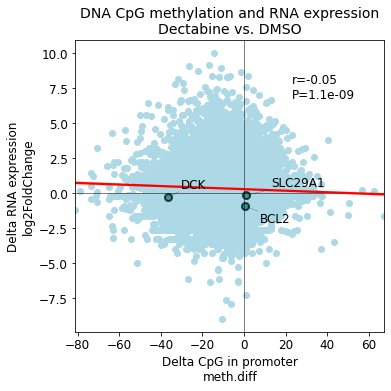

In [570]:
plot_scatter(
    X=pd.Series(hl60_DNAme_diff.loc[keep_DNAme_RNAexp,'meth.diff'].to_dict()),
    Y=pd.Series(hl60_RNAexp_diff.loc[keep_DNAme_RNAexp,'log2FoldChange'].to_dict()),
    genes=["DCK","SLC29A1","BCL2"],
    title='DNA CpG methylation and RNA expression\nDectabine vs. DMSO',
    xlabel = 'Delta CpG in promoter\nmeth.diff',# – qvalue < 0.05',
    ylabel = 'Delta RNA expression\nlog2FoldChange',# – pvalue < 0.05',
    rel=0.7,
    name='DNA-RNA-mtyl/DNAme-RNAexp-scatter.pdf'
)

### DNAme vs RNAstbl

In [322]:
keep_DNAme_RNAstbl = set(hl60_DNAme_diff[hl60_DNAme_diff.pvalue < 0.05].index) & \
    set(hl60_RNAstbl_diff.index)

In [323]:
len(keep_DNAme_RNAstbl)

514

In [ ]:
plot_scatter(
    X=hl60_DNAme_diff.loc[keep_DNAme_RNAstbl,'meth.diff'],
    Y=hl60_RNAstbl_diff.loc[keep_DNAme_RNAstbl,'log2FC'
    ],
    title='DNA CpG methylation and RNA Stability\nDectabine vs. DMSO',
    xlabel = 'Delta CpG in promoter\nmeth.diff – pvalue < 0.05',
    ylabel = 'Delta RNA stability\nlog2FoldChange – pvalue < 0.05',
    rel=0.7,
    # name='DNA-RNA-mtyl/DNAme-RNAexp-scatter.pdf'
)

### DNAme vs RNAme

In [325]:
keep_DNAme_RNAme = set(hl60_DNAme_diff[hl60_DNAme_diff.pvalue < 0.05].index) & \
    set(hl60_RNAme_diff[hl60_RNAme_diff.p_value < 0.05].index)

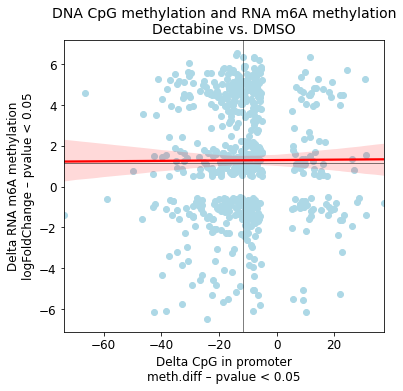

In [326]:
plot_scatter(
    X=hl60_DNAme_diff.loc[keep_DNAme_RNAme,'meth.diff'],
    Y=hl60_RNAme_diff.loc[keep_DNAme_RNAme,'logFC'],
    title='DNA CpG methylation and RNA m6A methylation\nDectabine vs. DMSO',
    xlabel = 'Delta CpG in promoter\nmeth.diff – pvalue < 0.05',
    ylabel = 'Delta RNA m6A methylation\nlogFoldChange – pvalue < 0.05',
    name='DNA-RNA-mtyl/DNAme-RNAme-scatter.pdf',
    rel=0.7
)

## 

In [46]:
# ls DNA-RNA-mtyl/Shareef-et-al-2021_HL60_10ng_*.cnt.txt

In [47]:
# def read_CpG_cnt_table(PATH):
#     df = pd.read_csv(PATH,sep='\t',header=None)
#     df.columns=['gene_id','transcript_id','gene_name','CpG']
#     df.CpG = np.log2(df.CpG + 0.5)
#     # stats.zscore(np.log2(df.CpG))
#     df.set_index('transcript_id',inplace=True)
#     df = df.sort_values('CpG').drop_duplicates(subset=['gene_name'],keep='last').set_index('gene_name')[['CpG']]
#     return df


In [48]:
# # from scipy import stats

# # decitabine
# hl60_CpG_promoter_decitabine = read_CpG_cnt_table(
#     'DNA-RNA-mtyl/Shareef-et-al-2021_HL60_10ng_decitabine.CpG-promoter.cnt.txt',
# )
# hl60_CpG_nearend_decitabine = read_CpG_cnt_table(
#     'DNA-RNA-mtyl/Shareef-et-al-2021_HL60_10ng_decitabine.CpG-nearend.cnt.txt',
# )

# # dmso
# hl60_CpG_promoter_dmso = read_CpG_cnt_table(
#     'DNA-RNA-mtyl/Shareef-et-al-2021_HL60_10ng_dmso.CpG-promoter.cnt.txt',
# )
# hl60_CpG_nearend_dmso = read_CpG_cnt_table(
#     'DNA-RNA-mtyl/Shareef-et-al-2021_HL60_10ng_dmso.CpG-nearend.cnt.txt',
# )

In [49]:
# hl60_m6A_fold_enrchment = pd.read_csv('meRIP-seq/exomepeak/WINDOW-50-STEP-5-LENGTH-150-ENRICH-1/peak.xls',sep='\t')[['name','fold_enrchment']]
# hl60_m6A_fold_enrchment.columns = ['gene_id','m6A']
# hl60_m6A_fold_enrchment.m6A = np.log2(hl60_m6A_fold_enrchment.m6A)
# hl60_m6A_fold_enrchment['gene_name'] =gene_id2name.gene_name[hl60_m6A_fold_enrchment.index].to_list()
# hl60_m6A_fold_enrchment = hl60_m6A_fold_enrchment.sort_values('m6A').drop_duplicates(subset='gene_name',keep='last')
# # hl60_m6A_fold_enrchment = hl60_m6A_fold_enrchment.sort_values('m6A').drop_duplicates(subset='transcript_id',keep='last')
# hl60_m6A_fold_enrchment = hl60_m6A_fold_enrchment.set_index('gene_name')[['m6A']]
# # hl60_m6A_fold_enrchment = hl60_m6A_fold_enrchment.set_index('transcript_id')[['m6A']]

In [50]:
# hl60_m6A_fold_enrchment.m6A.min(),hl60_m6A_fold_enrchment.m6A.max()

In [51]:
# hl60_m6A_fold_enrchment.hist(bins=100)
# plt.show()

### promoter

In [52]:
# a = set(hl60_CpG_promoter_decitabine.index) 
# b = set(hl60_CpG_promoter_dmso.index)
# c = set(hl60_m6A_fold_enrchment.index)

In [53]:
# overlap = a & b
# print (len(overlap))
# hl60_CpG_promoter_count = pd.concat([
#     hl60_CpG_promoter_decitabine.loc[overlap,['CpG']],
#     hl60_CpG_promoter_dmso.loc[overlap,['CpG']]
# ],axis=1)

In [54]:
# hl60_CpG_promoter_count.columns=['decitabine','dmso']

# plot_scatter(
#     X=hl60_CpG_promoter_count['decitabine'],Y=hl60_CpG_promoter_count['dmso'],
#     title='# CpG in promoter',
#     xlabel = 'log2(#CpG) - Decitabine',
#     ylabel = 'log2(#CpG) - DMSO',
#     genes = ['SQLE','INTS5','ASGR2',
#     ] + list(hl60_CpG_promoter_count.index[
#         (hl60_CpG_promoter_count.dmso> 4.6) & 
#         (hl60_CpG_promoter_count.decitabine < 1.5)]),
#     rel=0.6
# )

In [55]:
# overlap = list(b & c)
# print (len(overlap))

# DNA_RNA_me = pd.concat([
#     hl60_m6A_fold_enrchment.loc[overlap,['m6A']],
#     hl60_CpG_promoter_dmso.loc[overlap,['CpG']],
# ],axis=1)

# DNA_RNA_me.columns=['CpG','m6A']

# plot_scatter(
#     X=DNA_RNA_me['CpG'],
#     Y=DNA_RNA_me['m6A'],
#     title='CpG in promoter\nvs. m6A RNA methylation',
#     xlabel= 'log2(#CpG)',
#     ylabel='log2(fold_enrchment m6A)',
#     # genes = ['DNMT3A'] + list(DNA_RNA_me.index[
#     #     ((DNA_RNA_me['CpG'] < 3) &
#     #     (DNA_RNA_me['m6A'] > 7.8)) | 
#     #     ((DNA_RNA_me['CpG'] > 9) &
#     #     (DNA_RNA_me['m6A'] < 4))
#     # ]),    
#     rel=0.6
# )

In [56]:
# DNA_RNA_me.corr()

In [57]:
# DNA_RNA_me[['CpG']].to_csv('DNA-RNA-mtyl/CpG-promoter.txt',sep='\t')

### near end

In [369]:
# hl60_CpG_nearend_decitabine
# hl60_CpG_nearend_dmso

# hl60_m6A_fold_enrchment

In [58]:
# a = set(hl60_CpG_nearend_decitabine.index) 
# b = set(hl60_CpG_nearend_dmso.index)
# c = set(hl60_m6A_fold_enrchment.index)

In [59]:
# overlap = a & b
# print (len(overlap))
# hl60_CpG_nearend_count = pd.concat([
#     hl60_CpG_nearend_decitabine.loc[overlap,['CpG']],
#     hl60_CpG_nearend_dmso.loc[overlap,['CpG']]
# ],axis=1)

In [60]:
# hl60_CpG_nearend_count.columns=['decitabine','dmso']

# plot_scatter(
#     X=hl60_CpG_nearend_count['decitabine'],Y=hl60_CpG_nearend_count['dmso'],
#     title='# CpG in near end',
#     xlabel = 'log2(#CpG) - Decitabine',
#     ylabel = 'log2(#CpG) - DMSO',
#     genes = ['INTS5','DNMT3A','SQLE','LPIN3'
#     ] + list(hl60_CpG_nearend_count.index[
#         (hl60_CpG_nearend_count.dmso> 4.8) & 
#         (hl60_CpG_nearend_count.decitabine < 1.5)]),
#     rel=0.6
# )

In [61]:
# overlap = list(b & c)
# print (len(overlap))

# DNA_RNA_me = pd.concat([
#     hl60_m6A_fold_enrchment.loc[overlap,['m6A']],
#     hl60_CpG_nearend_dmso.loc[overlap,['CpG']],
# ],axis=1)

# DNA_RNA_me.columns=['CpG','m6A']

# plot_scatter(
#     X=DNA_RNA_me['CpG'],
#     Y=DNA_RNA_me['m6A'],
#     title='CpG in near end\nvs. m6A RNA methylation',
#     xlabel= 'log2(#CpG)',
#     ylabel='log2(fold_enrchment m6A)',
#     # genes = ['DNMT3A'] + list(DNA_RNA_me.index[
#     #     ((DNA_RNA_me['CpG'] < 3) &
#     #     (DNA_RNA_me['m6A'] > 7.8)) | 
#     #     ((DNA_RNA_me['CpG'] > 9) &
#     #     (DNA_RNA_me['m6A'] < 4))
#     # ]),    
#     rel=0.6
# )

In [62]:
# DNA_RNA_me.corr()

In [63]:
# DNA_RNA_me[['CpG']].to_csv('DNA-RNA-mtyl/CpG-nearend.txt',sep='\t')

In [198]:
# hl60_DNAme_df = pd.read_csv('DNA-RNA-mtyl/Shareef-et-al-2021-Supp-Table2.csv')
# hl60_DNAme_df['score'] = 0

In [199]:
# hl60_DNAme_df.score#loc[~hl60_DNAme_df["HL-60-specific hypermethylation"].isna(),:]

In [200]:
# hl60_RNAme_df

In [201]:
# hl60_DNAme_hyper = set(
#     # hl60_DNAme_df.Gene[hl60_DNAme_df['HL-60 average methylation'] > hl60_DNAme_df['HL-60 average methylation'].quantile(q=0.75)]
#     hl60_DNAme_df.loc[~hl60_DNAme_df["HL-60-specific hypermethylation"].isna(),"Gene"]
# )
# hl60_DNAme_hypo  = set(
#     # hl60_DNAme_df.Gene[hl60_DNAme_df['HL-60 average methylation'] < hl60_DNAme_df['HL-60 average methylation'].quantile(q=0.25)]
#     hl60_DNAme_df.loc[~hl60_DNAme_df["HL-60-specific hypomethylation"].isna(),"Gene"]
# )

# hl60_RNAme_hyper, hl60_RNAme_hypo = two_sided_mtyl(hl60_RNAme_df, fcthr=2, pvthr=0.01)
# hl60_RNAme_hyper = set(hl60_RNAme_hyper.name)
# hl60_RNAme_hypo  = set(hl60_RNAme_hypo.name)

In [64]:
# hl60_RNAme_hyper.intersection(hl60_DNAme_hypo)

In [65]:
# hl60_RNAme_hyper.intersection(hl60_DNAme_hyper)

<!-- > #### Enhancer recruitment of transcription repressors RUNX1 and TLE3 by mis-expressed FOXC1 blocks differentiation in acute myeloid leukemia
https://doi.org/10.1016/j.celrep.2021.109725 -->

In [66]:
# hl60_RNAme_hypo.intersection(hl60_DNAme_hyper)

In [67]:
# hl60_RNAme_hypo.intersection(hl60_DNAme_hypo)

In [68]:
# hl60_DNAme_bed = hl60_DNAme_df.loc[:,['Chromosome','Start','End','Gene','score','Strand','HL-60 average methylation']]
# hl60_DNAme_bed.columns = ['chr','start','end','name','score','strand','DNAme']
# hl60_DNAme_bed.start = hl60_DNAme_bed.start.str.replace(',','').astype(int)
# hl60_DNAme_bed.end   = hl60_DNAme_bed.end.str.replace(',','').astype(int)
# hl60_DNAme_bed = hl60_DNAme_bed.sort_values(['chr','start','end'])

# hl60_DNAme_bed.rename({'chr':'# chr'},axis=1).to_csv('DNA-RNA-mtyl/hl60_DNAme.bed',index=None,sep='\t')

In [69]:
# hl60_RNAme_bed = hl60_RNAme_df.iloc[:,list(range(0,6))+[12]].rename({'logFC':'RNAme'},axis=1).sort_values(['chr','start','end'])
# hl60_RNAme_bed.rename({'chr':'# chr'},axis=1).to_csv('DNA-RNA-mtyl/hl60_RNAme.bed',index=None,sep='\t')

In [70]:
# hl60_DNAme_bed

In [ ]:
# %%bash
# bedtools intersect -wo \
#     -a DNA-RNA-mtyl/hl60_RNAme.bed \
#     -b DNA-RNA-mtyl/hl60_DNAme.bed > hl60_intersect.bed

In [71]:
# hl60_intersect_df = pd.read_csv('DNA-RNA-mtyl/hl60_intersect.bed',sep='\t',header=None).iloc[:,list(range(0,7)) + [13,14]]
# hl60_intersect_df.columns = ['chr','start','end','name','score','strand','RNAme','DNAme','overlap']

In [72]:
# hl60_intersect_df

In [73]:
# wd = '/data_gilbert/home/aarab/Projects/Decitabine-treatment'

# comps = load_data(comparisons=True,wd=wd)
# scrns = load_data(screens=True,wd=wd)

In [74]:
# comps['delta_exp'].query('gene_name == "TREX1" or gene_name == "SLC39A7"')

In [75]:
# comps['delta_mtyl'].query('gene_name == "TREX1" or gene_name == "SLC39A7"')

In [76]:
# scrns['hl60_exp1_DAC_rho'].query('gene_name == "TREX1" or gene_name == "SLC39A7"')

<!-- > Systematic genetic mapping of necroptosis identifies SLC39A7 as modulator of death receptor trafficking
https://www.nature.com/articles/s41418-018-0192-6

> Transcriptomic analysis reveals proinflammatory signatures associated with acute myeloid leukemia progression
https://pubmed.ncbi.nlm.nih.gov/34619772/ -->

### What's next?!

We can use methods from this paper for more deep analysis - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4165364/

> Approaches for the Analysis and Interpretation of Whole Genome Bisulfite Sequencing Data
https://link.springer.com/protocol/10.1007%2F978-1-4939-7774-1_17


I saw this review paper "[The exploration of N6-deoxyadenosine methylation in mammalian genomes](https://link.springer.com/article/10.1007/s13238-021-00866-3)" and it seems bisulfite sequencing is specific for 5mC and we wouldn’t get 6mA data from that. 
Computational tools have been developed to detect 6mA in prokaryotes and Chlamydomonas from nanopore sequencing data. However, no such tool was developed for metazoan genomes, largely due to the lack of 6mA data at single-base resolution from an accurate method, like bisulfite sequencing for 5mC. 


AML TCGA DNAme http://firebrowse.org/?cohort=LAML&download_dialog=true#

https://www.frontiersin.org/articles/10.3389/fphar.2019.00385/full

# CanDI analysis 

There some missing data from DepMap in CanDI that I like to work with them here. So I downloaded them manually and I want to try explore them together with the CanDI's functionalities. 

    CCLE_metabolomics_20190502.csv
    CCLE_RRBS_cgi_CpG_clusters_20181119.txt.gz
    CCLE_RRBS_enh_CpG_clusters_20181119.txt.gz
    CCLE_RRBS_TSS1kb_20181022.txt.gz
    CCLE_RRBS_tss_CpG_clusters_20181022.txt.gz


In [ ]:
can.data.load('mutations')

,gene,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,isCOSMIChotspot,COSMIChsCnt,ExAC_AF,Variant_annotation,CGA_WES_AC,HC_AC,RD_AC,RNAseq_AC,SangerWES_AC,WGS_AC
0,VPS13D,55187,37,1,12359347,12359347,+,Nonsense_Mutation,SNP,C,...,False,0.0,NaN,damaging,34:213,NaN,NaN,NaN,34:221,NaN
1,AADACL4,343066,37,1,12726308,12726322,+,In_Frame_Del,DEL,CTGGCGTGACGCCAT,...,False,3.0,NaN,other non-conserving,57:141,NaN,NaN,NaN,9:0,28:32
2,IFNLR1,163702,37,1,24484172,24484172,+,Silent,SNP,G,...,False,0.0,NaN,silent,118:0,NaN,NaN,10:0,118:0,18:0
3,TMEM57,55219,37,1,25785018,25785019,+,Frame_Shift_Ins,INS,-,...,False,0.0,NaN,damaging,NaN,NaN,NaN,6:28,NaN,NaN
4,ZSCAN20,7579,37,1,33954141,33954141,+,Missense_Mutation,SNP,T,...,False,0.0,NaN,other non-conserving,28:62,NaN,NaN,NaN,27:61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226331,SLC39A4,55630,37,8,145641991,145641991,+,Silent,SNP,C,...,False,0.0,0.000017,silent,52:23,NaN,NaN,NaN,NaN,NaN
1226332,TAL2,6887,37,9,108424778,108424778,+,Start_Codon_SNP,SNP,A,...,False,0.0,NaN,damaging,27:0,NaN,NaN,NaN,NaN,NaN
1226333,TRO,7216,37,X,54955098,54955098,+,Silent,SNP,C,...,False,0.0,NaN,silent,5:16,NaN,NaN,NaN,NaN,NaN
1226334,USP51,158880,37,X,55514703,55514703,+,Missense_Mutation,SNP,G,...,False,0.0,NaN,other non-conserving,23:0,NaN,NaN,NaN,NaN,NaN


In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))


def pretty_print_attr(obj):
    attr = []
    ls_attr = []
    meth = []
    for i in dir(obj):
        if "_" != i[0]:
            if type(getattr(obj, i)) == str or type(getattr(obj, i)) == int:
                attr.append(i)
            elif type(getattr(obj, i)) == list:
                ls_attr.append(i)
            else:
                meth.append(i)

    print("Attributes:\n")
    for i in attr: print(i+":", getattr(obj, i))
    for i in ls_attr: print(i+" list first item:", getattr(obj, i)[0])
    for i in ls_attr: print(i+" length:", len(getattr(obj, i)))
    print("\nMethods:\n")
    for i in meth: print(i)

In [ ]:
def mt_wt_objs(cancer, genes):
    # Cell lines with mutation
    mt_list = cancer.mutated(genes)
    mt = can.CellLineCluster(mt_list) 

    # CellLineCluster ojbect must be instantiated with a mutable sequence
    # I use set operations to get wild type cell line ids and convert to a list
    wt_list = list(set(lu.depmap_ids) - set(mt_list)) 

    wt = can.CellLineCluster(wt_list) 
    print (f'#of mutated cell lines:\n\t{len(mt.depmap_ids)}')
    print (f'#of wildtype cell lines:\n\t{len(wt.depmap_ids)}')
    
    return mt, wt

In [ ]:
def gene_effect_heatmap(obj1, obj2, genes, name = None):
    #Make Figure appropriate size, dpi, and font
    plt.rcParams.update({"figure.figsize": (16, 6),
                        "savefig.dpi": 300,
                        "font.size": 12
                        })

    #One figure with one subplot
    fig, ax = plt.subplots(1,1)

    #Construcat matrix to make heatmap and cell line labels
    data = pd.concat([obj1.effect_of(genes), obj2.effect_of(genes)], axis=1)
    names = can.data.cell_lines.loc[data.columns, "cell_line_name"]

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(genes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(genes)

    #make heatmap
    im = ax.imshow(data, cmap="RdBu")

    #Make colorbar scale to axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = ax.figure.colorbar(im, ax = ax, cax = cax)
    cbar.ax.set_ylabel("Gene Effect", rotation=-90, va="bottom")

    #Draw Dividing line btween mutant and
    ax.axvline(x=obj1.gene_effect.shape[1] - 0.5, c = "black", linewidth = 3)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="left", va="center",
         rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

    if name:
        fig.savefig(name, dpi=300)

        
def gene_effect_scatter(mt, wt, genes=None, name_scatter='', return_effect=False, plot=True, name=None):

    # Average Gene Effect 
    mt_effect = mt.gene_dependency.mean(1)
    wt_effect = wt.gene_dependency.mean(1)

    if return_effect:
        return mt_effect, wt_effect
    
    if plot:
        #Make Figure appropriate size, dpi, and font
        plt.rcParams.update({"figure.figsize": (8, 8),
                            "savefig.dpi": 300,
                            "font.family": "sans-serif",
                            "font.size": 12
                            })

        #Generate Figure and Axis objects
        fig, ax = plt.subplots(1,1)

        #Label Axes
        ax.set_xlabel(f"{name_scatter} MT Average Gene Effect (CERES Score)")
        ax.set_ylabel(f"{name_scatter} WT Average Gene Effect (CERES Score)")

        #Draw Line at median common essential value
        ax.axhline(y = 0.50,
                   c = "black",
                   linewidth=0.5,
                   label = "Minimun Gene Dependencey Probability"
                  )

        ax.axvline(x = 0.50,
                   c= "black",
                   linewidth=0.5)

        #Plot all genes
        ax.scatter(mt_effect,
                   wt_effect,
                   c = "#2166ac",
                   alpha = 0.1,
                   s = 50
                  )

        ax.legend()

        if genes:
            #For Labeling
            if type(genes) != list:
                mt_lab = mt_effect.loc[[genes]]
                wt_lab = wt_effect.loc[[genes]]
            else:
                mt_lab = mt_effect.loc[genes]
                wt_lab = wt_effect.loc[genes]
            # Outline Genes To label
            ax.scatter(mt_lab,
                       wt_lab,
                       c = "#2166ac",
                       s = 50,
                       edgecolor = "black",
                       linewidth = 2,
                       alpha = 0.7
                      )
        #     for i in range(mt_lab.shape[0]):
        #         text = list(mt_lab.index)
        #         ax.annotate(text[i],
        #                     xy = (mt_lab[i], wt_lab[i]),
        #                     xytext = label[i],
        #                     xycoords = "data",
        #                     arrowprops = {"arrowstyle": "-"}
        #                    )
            texts = []
            for x, y, s in zip(mt_lab, wt_lab, mt_lab.index.tolist()):
                texts.append(plt.text(x, y, s))

            adjust_text(
                texts, force_points=0.2, force_text=0.2,
                expand_points=(2, 2), 
                expand_text=(2, 2),
                arrowprops=dict(arrowstyle="-", color='black', lw=0.2)
            )

        plt.show()

        if name:
            fig.savefig(name, dpi=300)


In [ ]:
cell_lines = can.data.cell_lines
genes = can.data.genes.index.tolist()

m6A = pd.read_csv('m6A-genes.tsv',sep='\t')
m6A_genes = [g.split(' ')[0] for g in m6A.Names if g in genes]

DNMT_genes = [g for g in genes if 'DNMT' in g]

In [ ]:
set(m6A.Type)

{'m6A eraser', 'm6A reader', 'm6A writer'}

In [ ]:
m6A_writer_genes = [g.split(' ')[0] for g in m6A[m6A.Type == 'm6A writer'].Names if g in genes] 
m6A_eraser_genes = [g.split(' ')[0] for g in m6A[m6A.Type == 'm6A eraser'].Names if g in genes] 

In [ ]:
lu = can.Cancer("Leukemia", subtype='AML')

# Number of Leukemia lines
print(len(lu.depmap_ids))

97


In [ ]:
can.data.mutations.columns

Index(['gene', 'Entrez_Gene_Id', 'NCBI_Build', 'Chromosome', 'Start_position',
       'End_position', 'Strand', 'Variant_Classification', 'Variant_Type',
       'Reference_Allele', 'Tumor_Seq_Allele1', 'dbSNP_RS', 'dbSNP_Val_Status',
       'Genome_Change', 'Annotation_Transcript', 'DepMap_ID', 'cDNA_Change',
       'Codon_Change', 'Protein_Change', 'isDeleterious', 'isTCGAhotspot',
       'TCGAhsCnt', 'isCOSMIChotspot', 'COSMIChsCnt', 'ExAC_AF',
       'Variant_annotation', 'CGA_WES_AC', 'HC_AC', 'RD_AC', 'RNAseq_AC',
       'SangerWES_AC', 'WGS_AC'],
      dtype='object')

In [ ]:
list(set(can.data.mutations.Protein_Change))[1:10]

['p.N1515K',
 'p.T1469M',
 'p.R43R',
 'p.P210H',
 'p.P258fs',
 'p.R3662P',
 'p.T58S',
 'p.S876Y',
 'p.C2157F']

### Analyzing Global Gene Dependency


> #### [Note-about-Gene-Effect-Scores:-Dependency-vs-Essentiality:](https://candi.readthedocs.io/en/latest/kras_egfr_scatter.html#Note-about-Gene-Effect-Scores:-Dependency-vs-Essentiality) 
A more negative gene effect means more dependent. A gene effect of -1.0 is the median gene effect of all common essential genes. If a gene has a gene effect of -1.0 or lower it then that gene is essential. A cell line can still be dependent on a gene with a lower gene effect if knocking out that gene slows growth/proliferation.



### m6A writer mutation

In [ ]:
m6A_mt, m6A_wt = mt_wt_objs(lu, m6A_writer_genes + ['TP53'])

#of mutated cell lines:
	28
#of wildtype cell lines:
	69


gene_effect has not been loaded. Do you want to load, y/n?> y
Load Complete


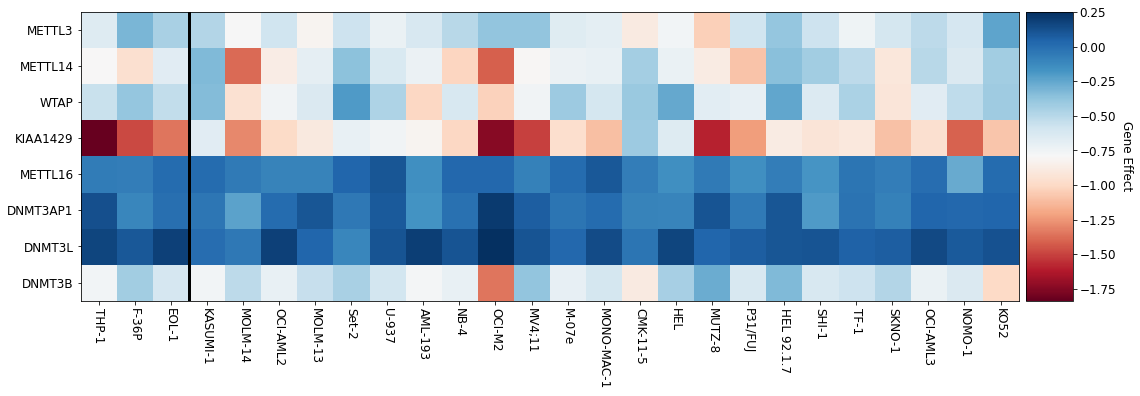

In [ ]:
gene_effect_heatmap(m6A_mt, m6A_wt,m6A_writer_genes + DNMT_genes)

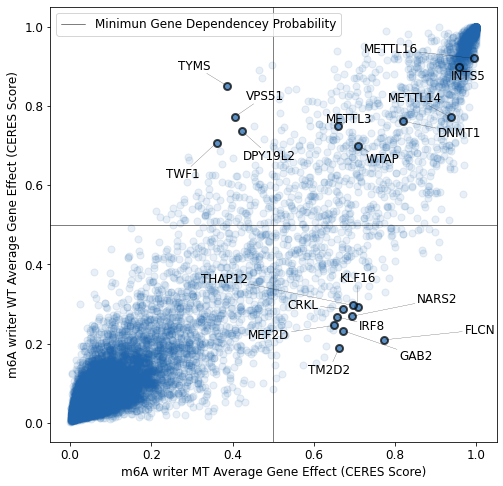

,inputGenes,p_value,fdr,description,term


In [ ]:
m6A_mt_effect, m6A_wt_effect = gene_effect_scatter(
    m6A_mt, m6A_wt,return_effect=True,plot=False
)

labels = intersection (
    m6A_mt_effect[m6A_mt_effect <= 0.45].index.tolist(),m6A_wt_effect[m6A_wt_effect >= 0.7].index.tolist()
) + intersection (m6A_mt_effect[m6A_mt_effect >= 0.65].index.tolist(),m6A_wt_effect[m6A_wt_effect <= 0.3].index.tolist())

gene_effect_scatter(
    m6A_mt, m6A_wt,
    genes=labels + ['DNMT1'] + ['INTS5'] + 
    [g for g in m6A_writer_genes if g in m6A_mt_effect.index.tolist()],
    name_scatter='m6A writer',
    name='DNA-RNA-mtyl-m6A-scatter.pdf'
)

run_enrichment(labels)

### INTS5 or m6A writer mutation

In [ ]:
mt, wt = mt_wt_objs(lu, m6A_writer_genes+['INTS5','TP53'])

#of mutated cell lines:
	30
#of wildtype cell lines:
	67


In [ ]:
# gene_effect_heatmap(DNMT_mt, DNMT_wt,m6A_writer_genes + DNMT_genes)

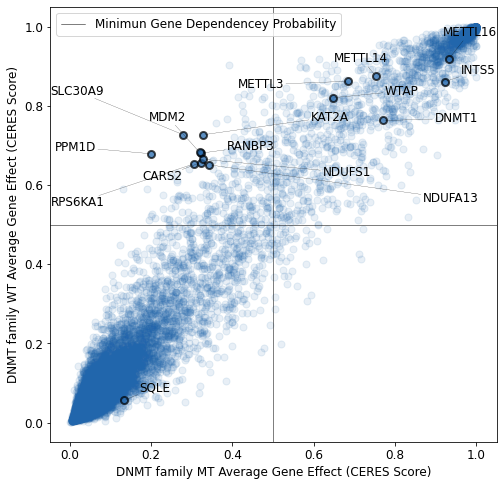

,inputGenes,p_value,fdr,description,term
0,"CARS2,NDUFS1,NDUFA13",0.000043,0.0401,Primary mitochondrial disease,KW-1274


In [ ]:
mt_effect, wt_effect = gene_effect_scatter(
    mt, wt,return_effect=True,plot=False
)

labels = intersection (
    mt_effect[mt_effect < 0.35].index.tolist(),wt_effect[wt_effect > 0.65].index.tolist()
) + intersection (mt_effect[mt_effect > 0.7].index.tolist(),wt_effect[wt_effect < 0.4].index.tolist())

gene_effect_scatter(
    mt, wt,
    genes=labels + ['DNMT1'] + ['INTS5', 'SQLE'] +
    [g for g in m6A_writer_genes if g in mt_effect.index.tolist()],
    name_scatter='DNMT family',
#     name='DNA-RNA-mtyl-DNmt-scatter.pdf'
)

run_enrichment(labels)

### DESeq analysis

In [ ]:
def make_counts_coldata(obj1, obj2, condition, factor1, factor2):

    counts1 = obj1.rnaseq_reads
    coldat1 = pd.Series(counts1.shape[1] * [factor1], index = counts1.columns, name = condition)

    counts2 = obj2.rnaseq_reads
    coldat2 = pd.Series(counts2.shape[1] * [factor2], index = counts2.columns, name = condition)

    #Concatenate Column Data
    coldat = pd.concat([coldat1, coldat2], axis = 0)
    #Concatenate read count data
    counts_mat = pd.concat([counts1, counts2], axis = 1)
    #Sum duplicate indeces
    counts_mat = counts_mat.groupby(counts_mat.index).sum().astype(int)

    return counts_mat, coldat

In [ ]:
counts_mat, coldat = make_counts_coldata(m6A_mt, m6A_wt,'mutation','mt','wt')

In [ ]:
coldat[coldat == 'mt']

ACH-000146    mt
ACH-000487    mt
ACH-000084    mt
ACH-000198    mt
Name: mutation, dtype: object

## CCLE DNA Methylation data

HL-60 raw data - https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR8633931

In [ ]:
depmap_data_path = str(pathlib.Path(can.__file__).resolve().parent.parent)+'/setup/data/depmap'

cgi_CpG_clusters = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_cgi_CpG_clusters_20181119.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

enh_CpG_clusters = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_enh_CpG_clusters_20181119.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

tss_CpG_clusters = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_tss_CpG_clusters_20181022.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

TSS1kb = pd.read_csv(
    f'{depmap_data_path}/CCLE_RRBS_TSS1kb_20181022.txt.gz',
    sep='\t', quotechar='"',low_memory=False
)

In [ ]:
# cgi_CpG_clusters

In [ ]:
# enh_CpG_clusters

In [ ]:
genes = {}

### TSS1kb

In [ ]:
tss1kb_hl60_df = TSS1kb.loc[
    :,['locus_id','CpG_sites_hg19','avg_coverage']+
    [col for col in TSS1kb.columns for aml in [
    'HL60_',#'OCIAML2','OCIAML2','KG1_'
] if aml in col]].dropna()
# .unique()


In [ ]:
data1 = tss1kb_hl60_df.loc[:,['locus_id','HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']].set_index('locus_id').astype('double')

In [ ]:
genes['tss1kb'],_,_,_ = zip(*
    data1[data1.iloc[:,0] > 0.95].index.str.split('_').tolist()
)
genes['tss1kb'] = set(tss1kb_hl60_genes)

### CpG

In [ ]:
tss_CpG_hl60_df = tss_CpG_clusters.loc[
    :,['cluster_id','CpG_sites_hg19','avg_coverage']+
    [col for col in TSS1kb.columns for aml in [
    'HL60_',#'OCIAML2','OCIAML2','KG1_'
] if aml in col]].dropna()
# .unique()

In [ ]:
data2 = tss_CpG_hl60_df.loc[:,['cluster_id','HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']].set_index('cluster_id').astype('double')

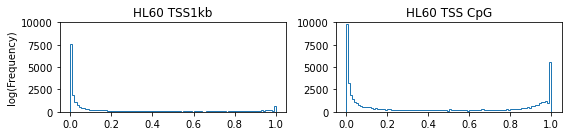

In [ ]:
# Set up the plot
f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,2))

ax1.hist(
    data1, histtype='step', stacked=False, fill=False, bins = 100, 
)
ax1.set_title('HL60 TSS1kb', size = 12)
ax1.set_ylabel('log(Frequency)', size= 10)
ax1.set_ylim(0,10000)

# Set up the plot
ax2 = plt.subplot(1, 2, 2)

ax2.hist(
    data2, histtype='step', stacked=False, fill=False, bins = 100, 
)
ax2.set_title('HL60 TSS CpG', size = 12)
ax2.set_ylim(0,10000)
# Title and labels

# f.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
genes['tss_CpG'] = set([x[0] for x in data[data.iloc[:,0] > 0.95].index.str.split('_').tolist()])

## CCLE metabolomics

    CCLE_metabolomics_20190502.csv


# 

In [405]:
!date

Fri Dec 17 19:26:37 PST 2021
